In [43]:
%matplotlib inline
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

3.3081853509067254
3.1957891328353045
1.3742288085461667
2.1273550527331975
2.9936897267094715


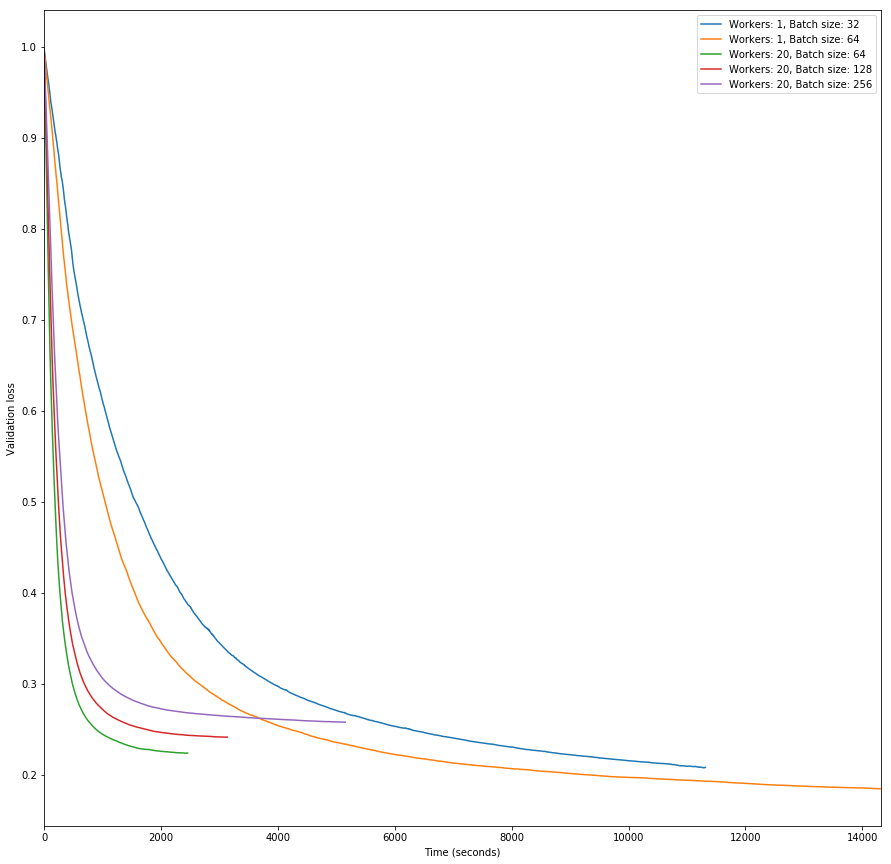

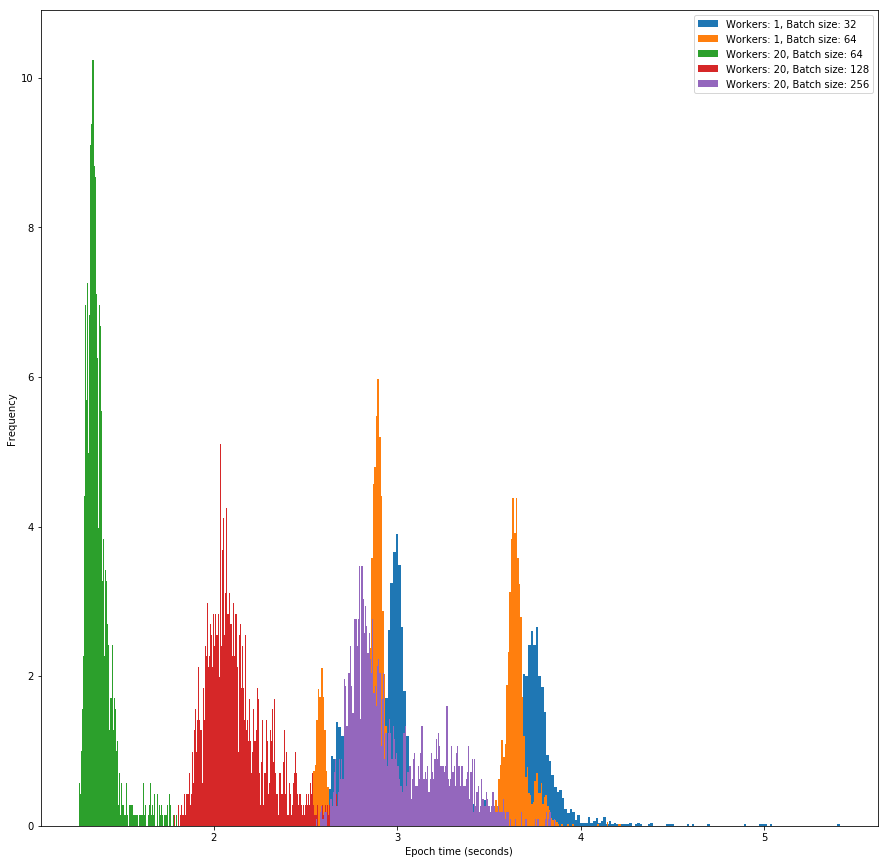

In [51]:
log_dir = "logs"
logs = [f for f in listdir(log_dir) if isfile(join(log_dir, f)) and '.' not in f]

PARENTHESIS_RE = "\((.*)\)"

def read_log(log_file):
    with open(join(log_dir, log_file), "r", encoding='latin-1') as f:
        lines = f.readlines()
        params = list(filter(lambda x: "PARAMETERS" in x, lines))
        assert len(params) == 1
        params = params[0].split()[2].split(',')
        params = dict(map(parse_params, params))
        
        losses = list(filter(lambda x: "SUMMARY" in x, lines))
        losses = list(map(read_summary, losses))
        
        events = list(filter(lambda x: "SUMMARY" not in x and "PARAMETERS" not in x, lines))
        events = list(map(read_time, events))
        df2 = pd.DataFrame.from_dict(events)
        df = pd.DataFrame.from_dict(losses)
        df = pd.concat([df, df2], sort=False).groupby("epoch").first().reset_index()
        for name, p in params.items():
            df[name] = p
        
        df["LOSS_COMPUTATION_TIME"] = (df["end_time"] - df["WEIGHTS_UPDATED_TIME"]) / 1000000000
        df["WEIGHTS_UPDATED_TIME"] = (df["WEIGHTS_UPDATED_TIME"] - df["GRADIENTS_MERGED_TIME"]) / 1000000000
        df["GRADIENTS_MERGED_TIME"] = (df["GRADIENTS_MERGED_TIME"] - df["GRADIENTS_COMPUTED_TIME"]) / 1000000000
        df["GRADIENTS_COMPUTED_TIME"] = (df["GRADIENTS_COMPUTED_TIME"] - df["START_TIME"]) / 1000000000
        df["end_time"] = (df["end_time"] - df["end_time"].min()) / 1000000000
        df.drop("START_TIME", axis=1, inplace=True)
        return df
        
def parse_params(param):
    split = param.split("=")
    key = split[0]
    value = split[1]
    try:
        value = int(value)
    except:
        try:
            value = float(value)
        except:
            pass
    return key, value
        
def read_summary(line):
    line = line.split()
    epoch = int(re.findall(PARENTHESIS_RE, line[1])[0])
    losses = re.findall(PARENTHESIS_RE, line[2])[0]
    time = float(line[3])
    train_loss, validation_loss = (float(i.split("=")[1]) for i in losses.split(","))
    return {"epoch": epoch, "end_time": time, "loss": train_loss, "val_loss": validation_loss}

def read_time(line):
    line = line.split()
    epoch = int(re.findall(PARENTHESIS_RE, line[1])[0])
    time = float(line[-1])
    event = line[2]
    return {"epoch": epoch, event + "_TIME": time}
    
    
data = list(map(read_log, logs))
data = reduce(lambda x, y: pd.concat([x,y]), data)
data = data.set_index(["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE", "epoch"])

def plot_all():
    fig = plt.figure(figsize=(15,15))
    ax = plt.gca()
    fig = plt.figure(figsize=(15,15))
    ax2 = plt.gca()
    labels = []
    for idx, df in data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
        label = "Workers: {}, Batch size: {}".format(idx[0], idx[1])
        df.plot(x="end_time", y="val_loss", ax=ax, label=label)
        time_diff = (df["end_time"] - df["end_time"].shift(1))
        
        time_diff.plot(kind='hist', ax=ax2, label=label, bins=200, density=True)
        print(time_diff.mean())
        labels.append(label)
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Validation loss")
    ax2.legend(labels)
    ax2.set_xlabel("Epoch time (seconds)")
plot_all()

[32, 64, 128, 256]
(1, 32) gradient computation 1.3408754187071033
(1, 32) gradient merge 0.0060229213855597765
(1, 32) weights update 0.00027639065594855307
(1, 32) loss computation 1.9667538648140894
(1, 64) gradient computation 1.3181505494597368
(1, 64) gradient merge 0.00692868855810841
(1, 64) weights update 0.00031020459826009366
(1, 64) loss computation 1.8749035489901833
(20, 64) gradient computation 0.5598746851152125
(20, 64) gradient merge 0.14507135272371366
(20, 64) weights update 0.0019646953998881432
(20, 64) loss computation 0.6732977037880313
(20, 128) gradient computation 0.8581049402747626
(20, 128) gradient merge 0.41220537239280874
(20, 128) weights update 0.002491278016282225
(20, 128) loss computation 0.8629807141763908
(20, 256) gradient computation 1.1658809305691058
(20, 256) gradient merge 1.0478890285011615
(20, 256) weights update 0.003573665742160279
(20, 256) loss computation 0.7828300152526132


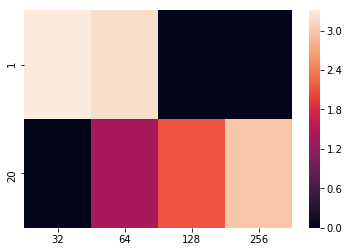

In [45]:
workers_value = sorted(map(int, data.index.levels[0].values))
batch_value = sorted(map(int, data.index.levels[1].values))
print(batch_value)
times = np.zeros((len(workers_value), len(batch_value)))
workers_idx = {w: i for i, w in enumerate(workers_value)}
batch_idx = {w: i for i, w in enumerate(batch_value)}
for idx, df in data.groupby(level=["WORKERS",  "BATCH_SIZE", "EPOCHS", "LEARNING_RATE", "PATIENCE"]):
    times[workers_idx[idx[0]], batch_idx[idx[1]]] = (df["end_time"] - df["end_time"].shift(1)).mean()
    print(idx[:2], "gradient computation", df["GRADIENTS_COMPUTED_TIME"].mean())
    print(idx[:2], "gradient merge", df["GRADIENTS_MERGED_TIME"].mean())
    print(idx[:2], "weights update", df["WEIGHTS_UPDATED_TIME"].mean())
    print(idx[:2], "loss computation", df["LOSS_COMPUTATION_TIME"].mean())
d = pd.DataFrame(times, columns=batch_idx.keys(), index=workers_idx.keys())
sns.heatmap(d);